# kNN и ансамбли деревьев решений

Выполнила: Блинова Елена, КЭ-128

In [102]:
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import scipy.stats as stats

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Задание

В этой работе Вы решаете задачу классификация ирисов Фишера с помощью метода kNN, реализуя его самостоятельно и используя возможности sklearn. Далее для той же задачи Вы используете ансамблевые модели на основе деревьев решений.

## 1. Используя метод k-NN, решить задачу классификации ирисов Фишера.

### Подготовка набора данных

In [2]:
iris = datasets.load_iris()
df = pd.DataFrame(
    iris.data,
    columns=iris.feature_names
    )

df['target'] = iris.target

target_names = {
    0:'setosa',
    1:'versicolor',
    2:'virginica'
}

df['target_names'] = df['target'].map(target_names)


In [3]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
 5   target_names       150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


### Визуализация набора данных

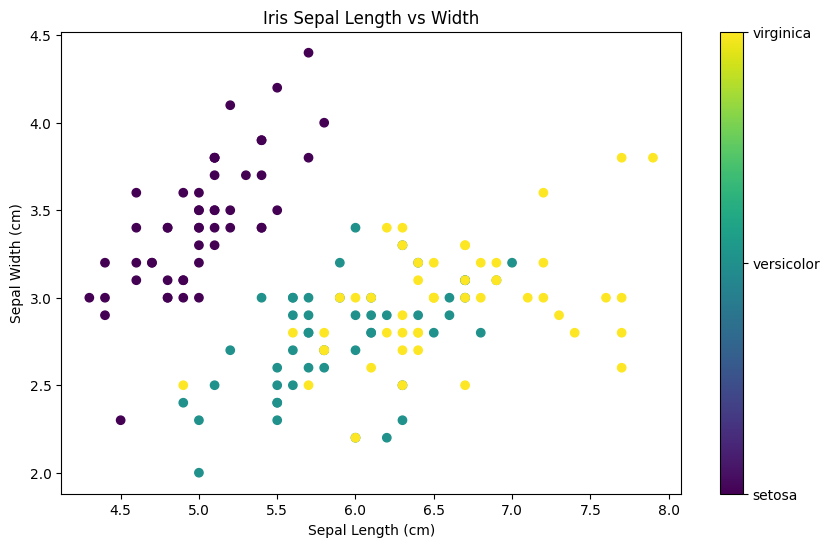

In [5]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['sepal length (cm)'], df['sepal width (cm)'], c=df['target'], cmap='viridis')
plt.colorbar(scatter, ticks=[0, 1, 2], format=plt.FuncFormatter(lambda val, loc: target_names[val]))
plt.title('Iris Sepal Length vs Width')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.show()

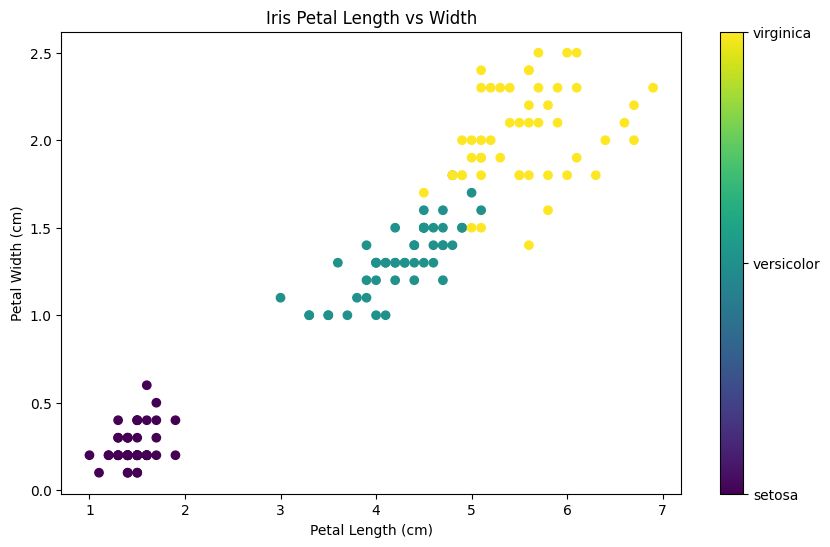

In [6]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['petal length (cm)'], df['petal width (cm)'], c=df['target'], cmap='viridis')
plt.colorbar(scatter, ticks=[0, 1, 2], format=plt.FuncFormatter(lambda val, loc: target_names[val]))
plt.title('Iris Petal Length vs Width')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.show()

### Проверка данных на нормальность

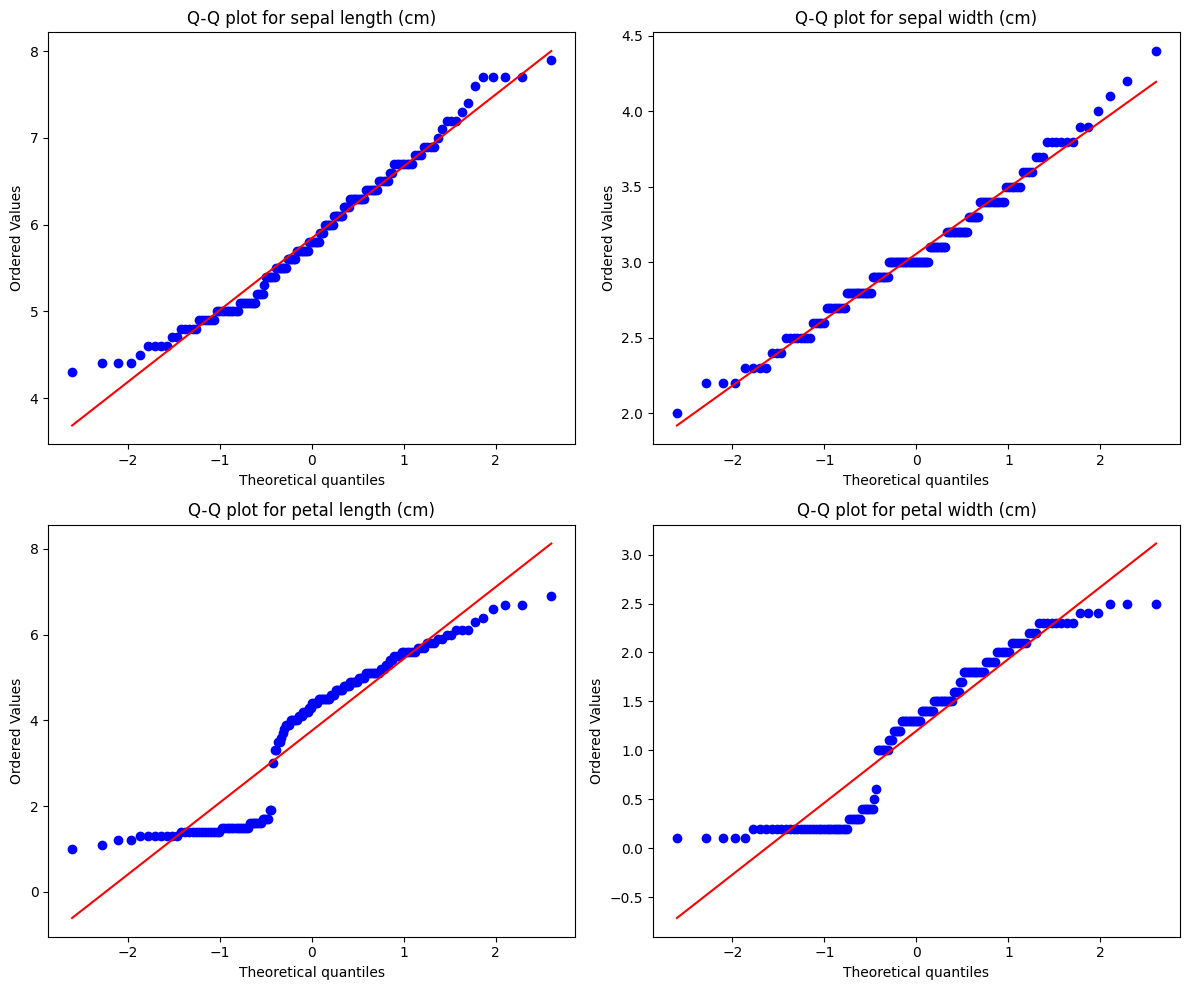

In [65]:
# Q-Q Plot для каждого признака
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, feature in enumerate(iris.feature_names):
    ax = axs[i // 2, i % 2]
    stats.probplot(df[feature], dist="norm", plot=ax)
    ax.set_title(f'Q-Q plot for {feature}')

plt.tight_layout()
plt.show()

### Решение задачи методом ближайших соседей

In [7]:
df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target', 'target_names'],
      dtype='object')

In [13]:
X = df.drop(['target', 'target_names'], axis=1).values  # Входные данные
y = df['target'].values  # Метки классов

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (150, 4)
y shape: (150,)


In [14]:
# Создание тестового набора данных из 10 экземпляров "цветов" разных классов
dataset = X[:150:15]
output = y[:150:15]

In [16]:
# Функция, вычисляющая евклидово расстояние между двумя векторами
def euclidean_distance(row1, row2):
    return np.sqrt(np.sum((row1 - row2) ** 2))

In [17]:
# Вычисление расстояний между всеми векторами тестового набора и dataset[5]
distances = [euclidean_distance(row, dataset[5]) for row in dataset]

for i, distance in enumerate(distances):
    print(f"Расстояние от dataset[{i}] до dataset[5]: {distance}")

Расстояние от dataset[0] до dataset[5]: 3.59722114972099
Расстояние от dataset[1] до dataset[5]: 3.4899856733230297
Расстояние от dataset[2] до dataset[5]: 3.539774004085572
Расстояние от dataset[3] до dataset[5]: 3.66742416417845
Расстояние от dataset[4] до dataset[5]: 2.128379665379276
Расстояние от dataset[5] до dataset[5]: 0.0
Расстояние от dataset[6] до dataset[5]: 1.1874342087037915
Расстояние от dataset[7] до dataset[5]: 2.5159491250818244
Расстояние от dataset[8] до dataset[5]: 1.6217274740226855
Расстояние от dataset[9] до dataset[5]: 2.2158519806160335


[Метод K-Nearest Neighbors. Разбор без использования бибилотек и с использованием бибилиотек](https://habr.com/ru/articles/680004/)

Метод kNN классификации: алгоритм по признакам считает расстояния между уже размеченными и еще неизвестными объектами в пространстве. Количество классов модель выясняет сама уже в процессе классификации: информация о классе содержится в самих объектах размеченных данных (во всех соседях)

Алгоритм kNN:
1. Вычислить расстояние от целевого объекта (который необходимо классифицировать) до каждого из объектов обучающей выборки (уже маркированных каким-либо классом).
2. Отобрать k объектов обучающей выборки, расстояния до которых минимальны (на первом этапе k выбирается произвольно, затем итеративно подбирается лучшее значение k на основе точности полученных прогнозов при каждом из выбранных k ).
3. Получить класс объекта на основе наиболее часто встречающегося среди k ближайших соседей (это может быть число или название класса в зависимости от того, как изначально были обозначены классы - например, в примере с беспилотниками это может быть "человек" или "бетонный блок").

In [21]:
#находит в train_set выборке k = num_neighbors ближайших соседей к даному (test_row).
def get_neighbors(train_set, labels, test_row, num_neighbors):
    # Создание и обучение модели K ближайших соседей
    neigh = NearestNeighbors(n_neighbors=num_neighbors)
    neigh.fit(train_set)

    # Нахождение ближайших соседей
    distances, indices = neigh.kneighbors([test_row])

    # Список k кортежей из 3 элементов: координата вектора, расстояние до test_row и метка класса
    return [(train_set[idx], distances[0][i], labels[idx]) for i, idx in enumerate(indices[0])]

In [22]:
# тестовый вызов функции get_neighbors на тестовом наборе
neighbors = get_neighbors(dataset, output, dataset[5], 3)
for neighbor in neighbors:
    print(neighbor)

(array([6.6, 3. , 4.4, 1.4]), 0.0, 1)
(array([5.5, 2.6, 4.4, 1.2]), 1.1874342087037915, 1)
(array([6.9, 3.2, 5.7, 2.3]), 1.6217274740226855, 2)


In [30]:
# Поиск метки класса, которому с большей вероятностью принадлежит test_row
def predict_classification(train_set, labels, test_row, num_neighbors):
    neighbors = get_neighbors(train_set, labels, test_row, num_neighbors)

    # Выбор меток классов ближайших соседей
    neighbor_labels = [neighbor[2] for neighbor in neighbors]

    # Определение наиболее часто встречающейся метки
    most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
    return most_common_label

In [31]:
# тестовый вызов функции predict_classification
prediction = predict_classification(dataset, output, dataset[5], 3)
print('Expected %d, Got %d.' % (output[5], prediction))

Expected 1, Got 1.


In [36]:
# Функция получает набор элементов test, определяет для каждого класс
# Возвращает список предсказанных ответов
def k_nearest_neighbors(train_set, labels, test_set, num_neighbors):
    predictions = []
    for test_row in test_set:
        prediction = predict_classification(train_set, labels, test_row, num_neighbors)
        predictions.append(prediction)
    return predictions

In [37]:
# разбиение выборки на обучающую и тестовую в соотношении: 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [44]:
predictions = k_nearest_neighbors(X_train, y_train, X_test, num_neighbors=2)

# Доля правильных ответов
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 93.33%


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
predictions = k_nearest_neighbors(X_train, y_train, X_test, num_neighbors=2)

# Доля правильных ответов
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 96.67%


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
predictions = k_nearest_neighbors(X_train, y_train, X_test, num_neighbors=2)

# Доля правильных ответов
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 100.00%


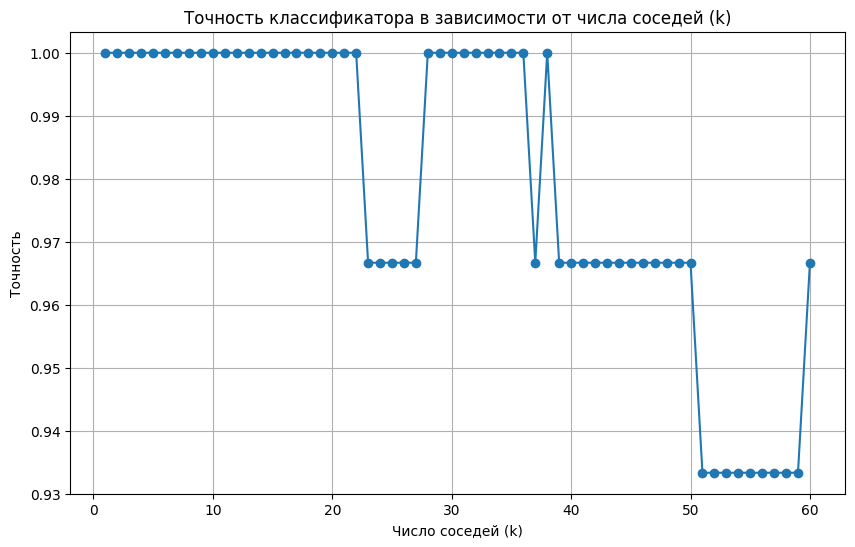

In [52]:
# Определение диапазона значений k
k_values = range(1, 61)
accuracies = []

# Вычисление точности для каждого значения k
for k in k_values:
    predictions = k_nearest_neighbors(X_train, y_train, X_test, k)
    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('Точность классификатора в зависимости от числа соседей (k)')
plt.xlabel('Число соседей (k)')
plt.ylabel('Точность')
plt.grid(True)
plt.show()

Оптимальные значения для выбора k находятся в диапазоне k=1,..,22.

### Сравнение точности классификации алгоритмов из библиотеки scikit-learn

Использование встроенного в библиотеке scikit-learn алгоритма kNN

[KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): Не строит явную модель, а хранит все обучающие данные и делает предсказания на основе ближайших соседей. Опирается на метки классов ближайших k соседей. Чаще всего используется для задач классификации. Качество предсказания сильно зависит от выбора значения k и метрики расстояния.

[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html): Параметрическая модель. Строит явную модель на основе линейной комбинации признаков. Использует сигмоидальную функцию для вычисления вероятности принадлежности к определенному классу. Обычно быстрее, чем kNN, особенно на больших наборах данных, так как обучение происходит один раз, а предсказания делаются быстро.



In [53]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
#K-Nearest Neighbors

knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='euclidean')
knn.fit(X_train, y_train)

knn_predictions = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print(f"KNN Accuracy: {knn_accuracy}")

KNN Accuracy: 1.0


In [57]:
# Logistic Regression

log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train, y_train)

log_reg_predictions = log_reg.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)
print(f"Logistic Regression Accuracy: {log_reg_accuracy}")

Logistic Regression Accuracy: 1.0


Точность классификаторов встроенных реализаций совпадает и равна 100%. Точность классификации собственной реализации колеблется от 93.33% до 100% в зависимости от выбранного количества ближайших соседей.

### Использование своих данных на построенных моделях:

*   собственная реализация
*   K-Nearest Neighbors
*   Logistic Regression






In [60]:
new_data = np.array([[5.1, 3.5, 1.4, 0.2]])
class_names = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}

In [61]:
# Предсказание класса для нового элемента на собственной реализации
predicted_class = predict_classification(X_train, y_train, new_data[0], num_neighbors=2)
print(f"Predicted class: {class_names[predicted_class]}")

Predicted class: setosa


In [62]:
# Предсказание класса для нового элемента на K-Nearest Neighbors
predicted_class_knn = knn.predict(new_data)
print(f"Predicted class (KNN): {class_names[predicted_class_knn[0]]}")

Predicted class (KNN): setosa


In [63]:
predicted_class_log_reg = log_reg.predict(new_data)
print(f"Predicted class (Logistic Regression): {class_names[predicted_class_log_reg[0]]}")

Predicted class (Logistic Regression): setosa


## 2. Использование деревьев решений и их ансамблей для задачи классификации ирисов Фишера

Обучить классификаторы на основе деревьев решений. Использовать методы, реализованные в sklearn.

Дерево решений: обучает одно дерево, делая последовательные разбиения на основе признаков, чтобы создать модель. Минусы: высокая чувствительность к переобучению

Случайный лес: ансамблевый метод, который обучает множество деревьев решений на разных подвыборках данных и усредняет их предсказания. Низкая чувствительность к переобучению. Более сложен в обучении.

Градиентный бустинг: ансамблевый метод, который создает последовательные деревья, каждое из которых исправляет ошибки предыдущих. Чувствителен к переобучению при неправильной настройке параметров. Требует больше времени и вычислительных ресурсов по сравнению с двумя другими методами.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80)

### 1) обучение одного дерева
[DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Train Accuracy: 1.0
Test Accuracy: 0.9666666666666667


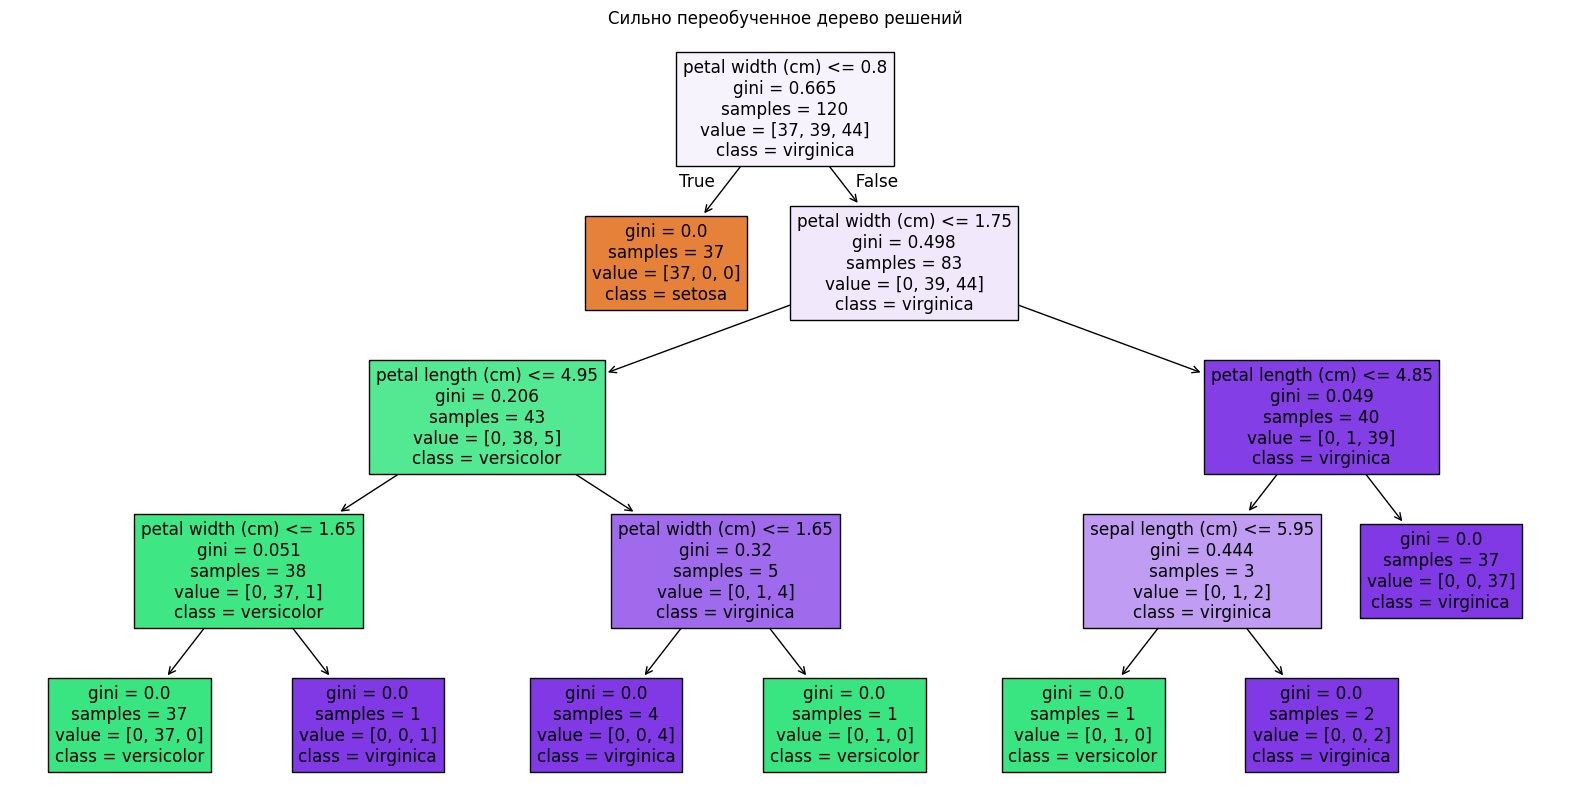

In [85]:
# Обучение сильно переобученного дерева решений
overfitted_tree = DecisionTreeClassifier(random_state=80, max_depth=None, min_samples_split=2, min_samples_leaf=1)
overfitted_tree.fit(X_train, y_train)

# Оценка точности на обучающем и тестовом наборах
train_accuracy = overfitted_tree.score(X_train, y_train)
test_accuracy = overfitted_tree.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Визуализация сильно переобученного дерева решений
plt.figure(figsize=(20, 10))
plot_tree(overfitted_tree, filled=True, feature_names=iris.feature_names, class_names=iris.target_names)
plt.title("Сильно переобученное дерево решений")
plt.show()

Train Accuracy: 0.975
Test Accuracy: 0.9666666666666667


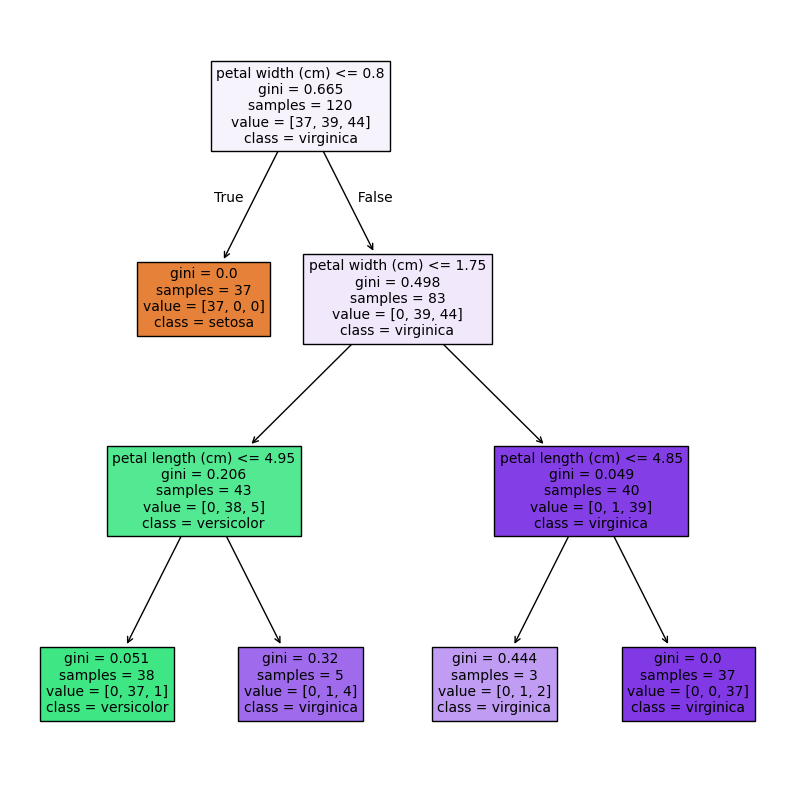

In [83]:
# Ограничение глубины дерева
tree = DecisionTreeClassifier(max_depth=3, random_state=80)
tree.fit(X_train, y_train)

# Оценка точности на обучающем и тестовом наборах
train_accuracy = tree.score(X_train, y_train)
test_accuracy = tree.score(X_test, y_test)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Визуализация дерева решений
plt.figure(figsize=(10, 10))
plot_tree(tree, filled=True, feature_names=iris.feature_names, class_names=iris.target_names)
plt.show()

In [86]:
new_data = np.array([[5.1, 3.5, 1.4, 0.2]])
class_names = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
predicted_class = tree.predict(new_data)
print(f"Predicted class: {class_names[predicted_class[0]]}")

Predicted class: setosa


### 2) случайный лес
[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Случайный лес — это ансамблевый метод, который создает множество деревьев решений и объединяет их результаты. Параметры модели:

n_estimators: количество деревьев в лесу. Большее количество деревьев может улучшить точность, но требует больше вычислительных ресурсов.

max_depth: максимальная глубина каждого дерева. Ограничивает глубину, чтобы предотвратить переобучение.

min_samples_split: минимальное количество образцов, необходимых для разбиения узла. Большие значения помогают избежать переобучения.

min_samples_leaf: минимальное количество образцов, необходимых для существования листа. Аналогично, большие значения уменьшают переобучение.

max_features: максимальное количество признаков, рассматриваемых для разделения каждого узла. Позволяет контролировать случайность модели.

bootstrap: использование повторной выборки при создании деревьев. Увеличивает устойчивость модели.

In [88]:
# Обучение случайного леса с базовыми параметрами
forest = RandomForestClassifier(random_state=80)
forest.fit(X_train, y_train)

# Оценка точности на тестовом и тренировочном наборах
train_accuracy = accuracy_score(y_train, forest.predict(X_train))
test_accuracy = accuracy_score(y_test, forest.predict(X_test))

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 1.0
Test Accuracy: 0.9666666666666667


In [96]:
# Влияние различных параметров на точность модели

# Увеличение числа деревьев
forest2 = RandomForestClassifier(n_estimators=100, random_state=80)
forest2.fit(X_train, y_train)
accuracy_more_trees = accuracy_score(y_test, forest2.predict(X_test))
train_accuracy = accuracy_score(y_train, forest2.predict(X_train))
print(f"Train Accuracy: {train_accuracy}")
print(f"Accuracy with more trees (n_estimators=100): {accuracy_more_trees}")

Train Accuracy: 1.0
Accuracy with more trees (n_estimators=100): 0.9666666666666667


In [97]:
# Ограничение глубины деревьев
forest3 = RandomForestClassifier(max_depth=3, random_state=80)
forest3.fit(X_train, y_train)

accuracy_limited_depth = accuracy_score(y_test, forest3.predict(X_test))
train_accuracy = accuracy_score(y_train, forest3.predict(X_train))

print(f"Train Accuracy: {train_accuracy}")
print(f"Accuracy with limited depth (max_depth=3): {accuracy_limited_depth}")

Train Accuracy: 0.975
Accuracy with limited depth (max_depth=3): 0.9666666666666667


In [98]:
# Изменение числа минимальных образцов для разбиения
forest4 = RandomForestClassifier(min_samples_split=10, random_state=80)
forest4.fit(X_train, y_train)

accuracy_split = accuracy_score(y_test, forest4.predict(X_test))
train_accuracy = accuracy_score(y_train, forest4.predict(X_train))

print(f"Train Accuracy: {train_accuracy}")
print(f"Accuracy with min_samples_split=10: {accuracy_split}")

Train Accuracy: 0.975
Accuracy with min_samples_split=10: 0.9666666666666667


In [99]:
# Использование минимального количества образцов для листа
forest5 = RandomForestClassifier(min_samples_leaf=5, random_state=80)
forest5.fit(X_train, y_train)

accuracy_leaf = accuracy_score(y_test, forest5.predict(X_test))
train_accuracy = accuracy_score(y_train, forest5.predict(X_train))

print(f"Train Accuracy: {train_accuracy}")
print(f"Accuracy with min_samples_leaf=5: {accuracy_leaf}")

Train Accuracy: 0.975
Accuracy with min_samples_leaf=5: 0.9666666666666667


In [101]:
# Изменение числа признаков для разделения каждого узла
forest6 = RandomForestClassifier(max_features='sqrt', random_state=80)
forest6.fit(X_train, y_train)

accuracy_features = accuracy_score(y_test, forest6.predict(X_test))
train_accuracy = accuracy_score(y_train, forest6.predict(X_train))

print(f"Train Accuracy: {train_accuracy}")
print(f"Accuracy with max_features='sqrt': {accuracy_features:.2f}")

Train Accuracy: 1.0
Accuracy with max_features='sqrt': 0.97


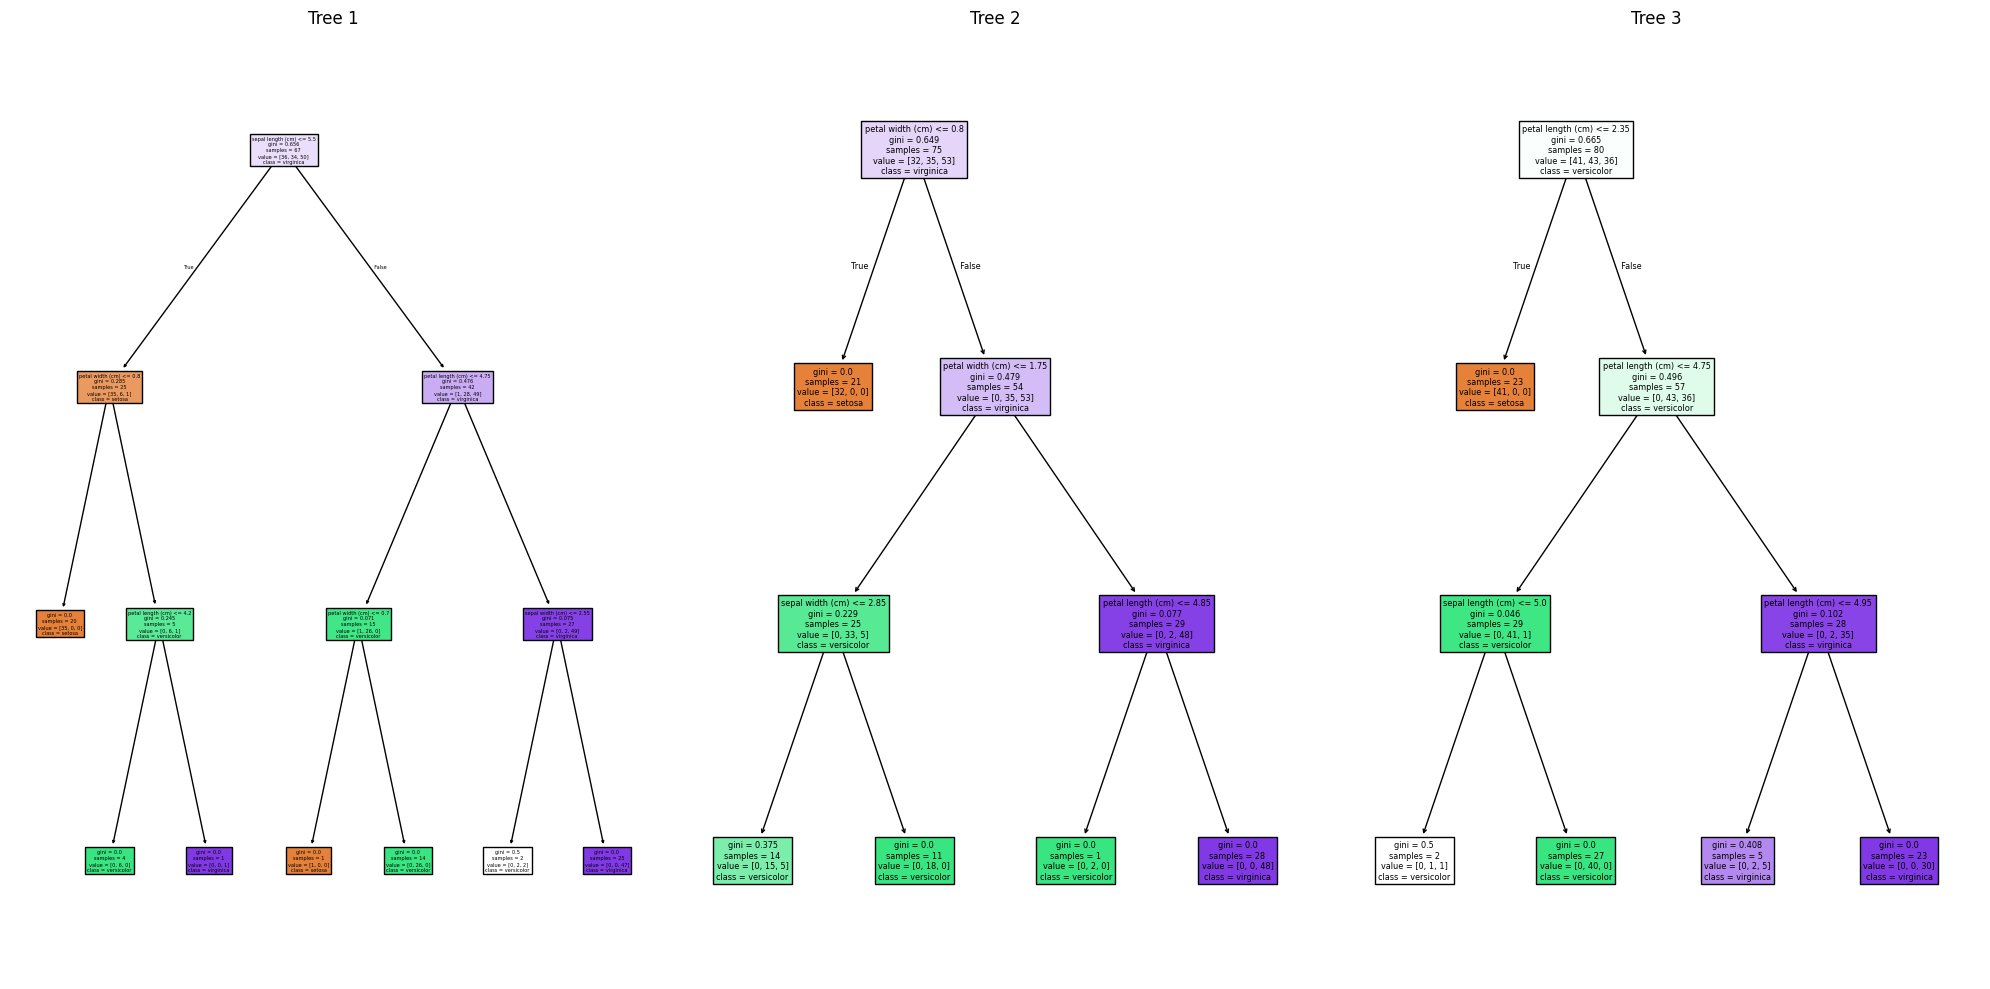

In [103]:
# Визуализация некоторых деревьев случайного леса
plt.figure(figsize=(20, 10))
for i in range(min(3, len(forest3.estimators_))):  # первые три дерева
    plt.subplot(1, 3, i + 1)
    plot_tree(forest3.estimators_[i], filled=True, feature_names=iris.feature_names, class_names=iris.target_names)
    plt.title(f"Tree {i + 1}")
plt.tight_layout()
plt.show()

In [105]:
predicted_class = forest3.predict(new_data)
print(f"Predicted class: {class_names[predicted_class[0]]}")

Predicted class: setosa


### 3) градиентный бустинг
Градиентный бустинг –  ансамблевый метод, который объединяет слабые модели в сильные, последовательно исправляя ошибки предыдущих моделей. Параметры:

n_estimators: количество деревьев в ансамбле. Большее число деревьев может улучшить производительность, но увеличивает время обучения и предсказания.

learning_rate: размер шага для каждого дерева. Меньшие значения делают обучение более устойчивым, но требуют большего количества деревьев.

max_depth: максимальная глубина дерева. Ограничивает сложность каждого дерева для предотвращения переобучения.

min_samples_split: минимальное количество образцов, необходимых для разделения узла. Большие значения уменьшают переобучение.

min_samples_leaf: минимальное количество образцов в листе. Аналогично, большие значения уменьшают переобучение.

subsample: доля выборки, используемой для обучения каждого дерева. Уменьшение значения увеличивает случайность модели и снижает переобучение

In [116]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

In [107]:
# Обучение градиентного бустинга с базовыми параметрами
gbc = GradientBoostingClassifier(random_state=80)
gbc.fit(X_train, y_train)

evaluate_model(gbc)

Train Accuracy: 1.00
Test Accuracy: 0.97


In [109]:
# Влияние различных параметров на точность модели

# Увеличение числа деревьев
gbc2 = GradientBoostingClassifier(n_estimators=100, random_state=80)
gbc2.fit(X_train, y_train)
evaluate_model(gbc2)

Train Accuracy: 1.00
Test Accuracy: 0.97


In [111]:
# Ограничение глубины деревьев
gbc3 = GradientBoostingClassifier(max_depth=2, random_state=80)
gbc3.fit(X_train, y_train)
evaluate_model(gbc3)

Train Accuracy: 1.00
Test Accuracy: 0.97


In [112]:
# Изменение числа минимальных образцов для разбиения
gbc4 = GradientBoostingClassifier(min_samples_split=10, random_state=80)
gbc4.fit(X_train, y_train)
evaluate_model(gbc4)

Train Accuracy: 1.00
Test Accuracy: 0.97


In [113]:
# Использование минимального количества образцов для листа
gbc5 = GradientBoostingClassifier(min_samples_leaf=5, random_state=80)
gbc5.fit(X_train, y_train)
evaluate_model(gbc5)

Train Accuracy: 1.00
Test Accuracy: 0.97


In [115]:
# Изменение доли выборки для каждого дерева
gbc6 = GradientBoostingClassifier(subsample=0.8, random_state=80)
gbc6.fit(X_train, y_train)
evaluate_model(gbc6)

Train Accuracy: 1.00
Test Accuracy: 0.97


In [118]:
# Обучение градиентного бустинга с ограничением параметров
gbc7 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.01, max_depth=2, min_samples_split=5, min_samples_leaf=5, subsample=0.8, random_state=80)
gbc7.fit(X_train, y_train)
evaluate_model(gbc7)

Train Accuracy: 0.975
Test Accuracy: 0.9666666666666667


In [119]:
predicted_class = gbc7.predict(new_data)
print(f"Predicted class: {class_names[predicted_class[0]]}")

Predicted class: setosa


### Важность признаков

In [124]:
print("Важность признаков для обычного дерева:\n{}".format(tree.feature_importances_))

Важность признаков для обычного дерева:
[0.         0.         0.07885581 0.92114419]


In [125]:
print("Важность признаков для случайного леса:\n{}".format(forest3.feature_importances_))

Важность признаков для случайного леса:
[0.09683154 0.01811361 0.45089551 0.43415933]


In [126]:
print("Важность признаков для градиентного бустинга:\n{}".format(gbc7.feature_importances_))

Важность признаков для градиентного бустинга:
[0.00115871 0.00114202 0.50644695 0.49125232]
